# Livrable 2 - Traitement d'images

Groupe 2 :
- Brenda DJIGUEMDE
- Bruno DIAS
- Dany KHADHAR
- Romaric DEMBELE

INTRODUCTION

Le but est de traiter un ensemble de photographies afin de les rendre mieux traitables par les algorithmes de Machine Learning. Le traitement à réaliser est une opération de débruitage. Vous devrez produire un notebook Jupyter explicitant ces étapes de prétraitement, et leurs performances. Ces algorithmes s'appuieront sur les auto-encodeurs à convolution, et les appliqueront pour améliorer la qualité de l'image.

Cahier de charges du livrable :

- Le code de chargement du fichier.
- Le code du débruitage sur un sous-ensemble d'images bruitées. Le code doit être accompagné d'explications.
- Une étude de cas.

Imports de librairies

In [62]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Variables globales

In [81]:
BATCH_SIZE = 32  # Taille du batch
DATASET_PATH = './dataset_livrable_2' 

# Configuration de paramètres pour l'entraînement
EPOCHS = 10 # Nombre d'époques pour l'entraînement
STEPS_PER_EPOCH  = 100  # Nombre de batches d'entraînement par époque
VALIDATION_STEPS = 50  # Nombre de batches de validation par époque

## 1. Chargement des données

In [63]:
# Création d'un DataFrame contenant les chemins des images
image_paths = [os.path.join(DATASET_PATH, f) for f in os.listdir(DATASET_PATH) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
image_df = pd.DataFrame({'filename': image_paths})

# Configuration de l'ImageDataGenerator pour la normalisation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Création du générateur de données d'entraînement et de validation
train_generator = datagen.flow_from_dataframe(
    dataframe=image_df,
    x_col='filename',
    y_col=None,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode=None,  # Pas de labels car l'image est sa propre cible
    batch_size=BATCH_SIZE,
    subset='training',  # Défini pour utiliser la répartition de validation
    shuffle=True
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=image_df,
    x_col='filename',
    y_col=None,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode=None,  # Pas de labels
    batch_size=BATCH_SIZE,
    subset='validation',  # Défini pour utiliser la répartition de validation
    shuffle=True
)

# Affichage des informations sur le générateur
for data_batch in train_generator:
    print('Batch shape:', data_batch.shape)
    break  # Affiche seulement le premier lot


Found 119 validated image filenames.
Found 29 validated image filenames.


Batch shape: (32, 224, 224, 3)


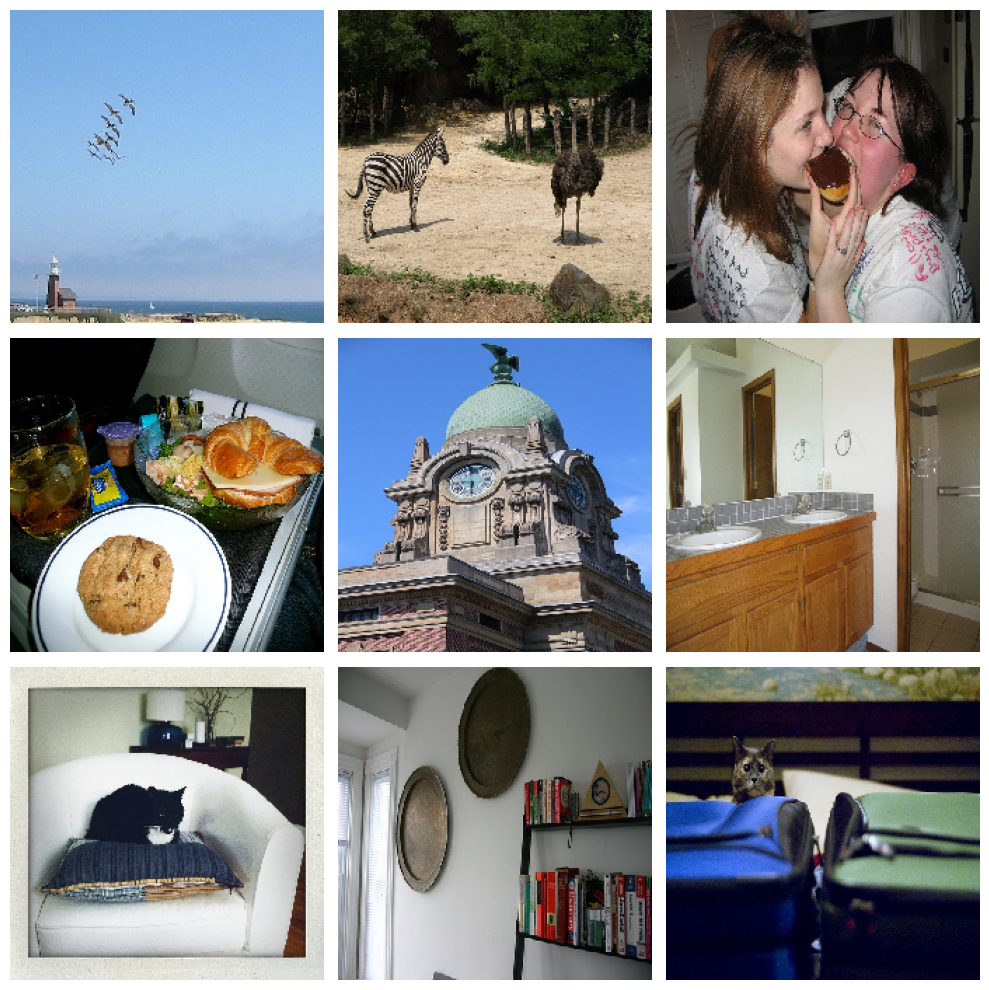

In [64]:
import matplotlib.pyplot as plt

def show_images(train_generator):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # Crée un grid de 3x3 pour les images
    axes = axes.flatten()
    batch = next(iter(train_generator))  # Récupère un lot d'images du générateur
    for i, ax in enumerate(axes):
        if i < len(batch):  # Vérifie si l'index est inférieur au nombre d'images dans le lot
            ax.imshow(batch[i])  # Affiche l'image dans le subplot
            ax.axis('off')  # Désactive les axes
    plt.tight_layout()  # Ajuste la disposition
    plt.show()

# Appelez la fonction pour montrer les images
show_images(train_generator)


## 2. Création d'un jeu de données bruité

In [65]:
# Fonction pour ajouter du bruit gaussien aux images
def add_noise(img, noise_level=0.1):
    '''Ajoute un bruit gaussien aléatoire à une image.'''
    noise = np.random.normal(loc=0.0, scale=noise_level, size=img.shape)
    img_noisy = img + noise
    img_noisy = np.clip(img_noisy, 0, 1)  # Garantir que les valeurs restent dans [0, 1]
    return img_noisy

def noisy_generator(generator, noise_level=0.1):
    '''Generates pairs of noisy and original images.'''
    for batch in generator:
        original_batch = batch.copy()  # Copy the original images before adding noise
        noisy_batch = np.array([add_noise(image, noise_level) for image in original_batch])
        yield noisy_batch, original_batch  # Yield both the noisy and the original images


In [66]:
train_dataset = tf.data.Dataset.from_generator(
    lambda: noisy_generator(train_generator, noise_level=0.1),
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # Noisy images
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32)   # Original images
    )
)

validation_dataset = tf.data.Dataset.from_generator(
    lambda: noisy_generator(validation_generator, noise_level=0.1),
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # Noisy images
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32)   # Original images
    )
)

# Example usage with TensorFlow training loop
for x, y in train_dataset.take(1):
    print('Batch shape:', x.numpy().shape)

Batch shape: (32, 224, 224, 3)


In [67]:
import matplotlib.pyplot as plt

def show_data_set_images(train_dataset):
    # Generate one batch from the dataset
    try:
        noisy_batch, original_batch = next(iter(train_dataset))
    except StopIteration:
        print("No more data available in the dataset.")
        return

    # Determine how many image pairs we can show
    num_images = len(noisy_batch)  # Get the number of images in the batch
    num_pairs_to_show = min(num_images, 9)  # Can show up to 9 pairs (since there are 18 subplots)

    # Set up the figure with a grid of 3 rows and 6 columns
    fig, axes = plt.subplots(3, 6, figsize=(15, 10))
    axes = axes.flatten()

    for i in range(num_pairs_to_show):
        # Display the noisy image on the left
        ax_noisy = axes[2 * i]
        ax_noisy.imshow(noisy_batch[i])
        ax_noisy.axis('off')
        ax_noisy.set_title('Noisy Image')

        # Display the original image on the right
        ax_original = axes[2 * i + 1]
        ax_original.imshow(original_batch[i])
        ax_original.axis('off')
        ax_original.set_title('Original Image')

    # Hide any remaining unused axes
    for j in range(2 * num_pairs_to_show, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


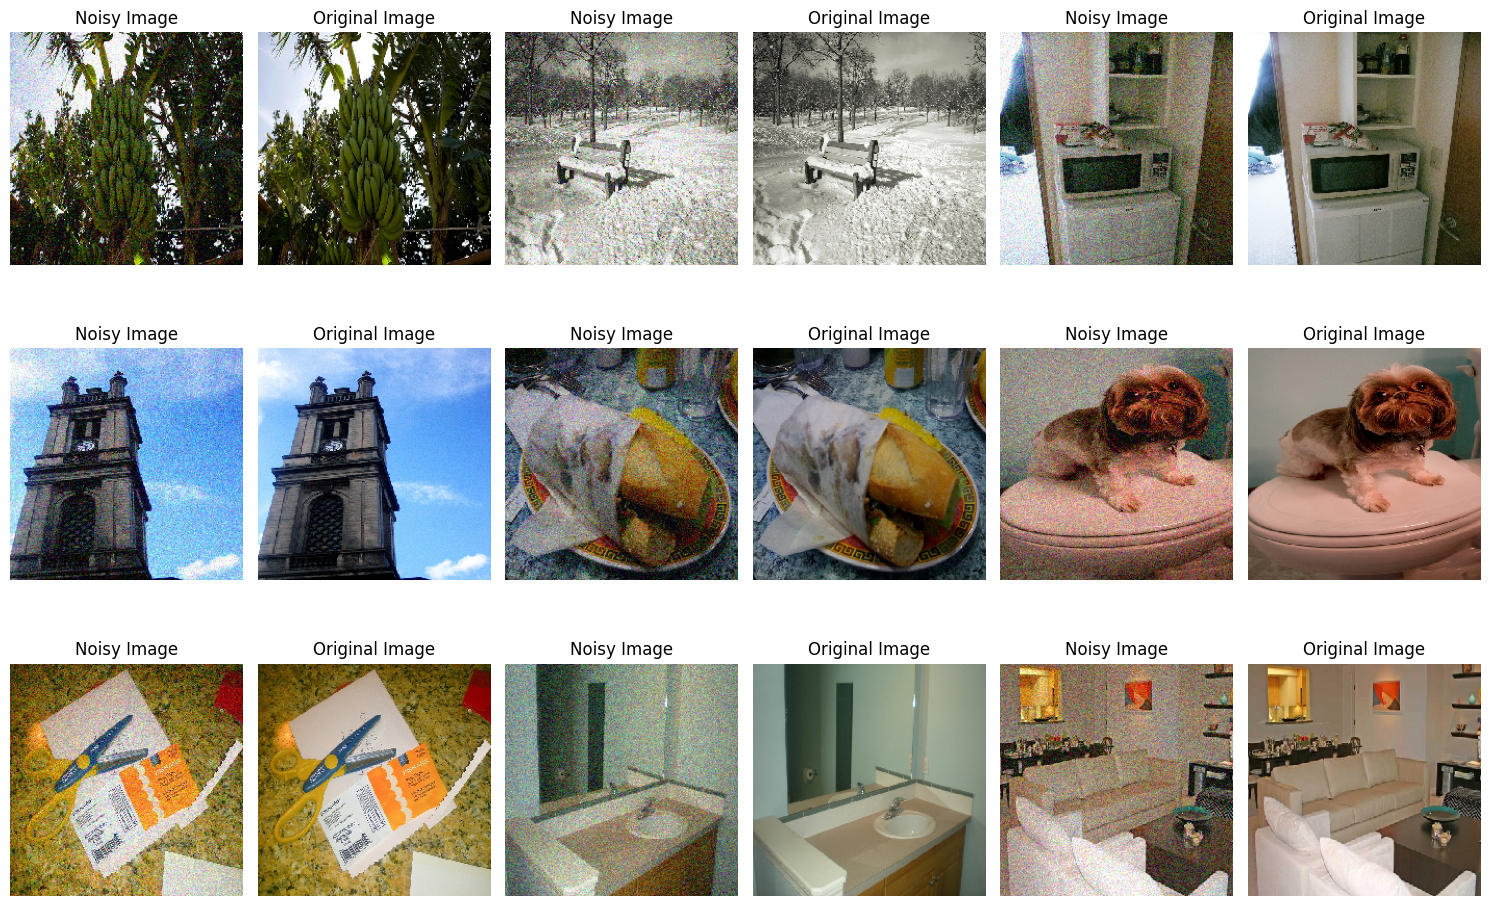

In [68]:
# Affichage des images bruitées
show_data_set_images(train_dataset)

## 3. Création du modèle autoencodeur

In [72]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

def build_autoencoder(input_shape=(224, 224, 3)):
    input_img = Input(shape=input_shape)
    
    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # Ensure padding is 'same'
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Create the autoencoder model
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return autoencoder

# Build and summarize the autoencoder model
autoencoder = build_autoencoder()
autoencoder.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 56, 56, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 28, 28, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 28, 28, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_12 (UpSampling2D) │ (None, 56, 56, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 56, 56, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_13 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_14 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 224, 224, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,939 (54.45 KB)

 Trainable params: 13,939 (54.45 KB)

 Non-trainable params: 0 (0.00 B)

In [75]:
# Entraînement de l'autoencodeur
history = autoencoder.fit(
    x=train_dataset,  # Données d'entraînement
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_dataset,  # Données de validation
    validation_steps=VALIDATION_STEPS
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - loss: 0.0150 - val_loss: 0.0134
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - loss: 0.0137 - val_loss: 0.0129
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - loss: 0.0133 - val_loss: 0.0124
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - loss: 0.0127 - val_loss: 0.0120
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 78s 788ms/step - loss: 0.0123 - val_loss: 0.0117
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 78s 780ms/step - loss: 0.0122 - val_loss: 0.0114
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 69s 693ms/step - loss: 0.0119 - val_loss: 0.0112
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 62s 626ms/step - loss: 0.0117 - val_loss: 0.0114
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 595ms/step - loss: 0.0116 - val_loss: 0.0109
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 55s 553ms/step - loss: 0.0114 - val_loss: 0.0109


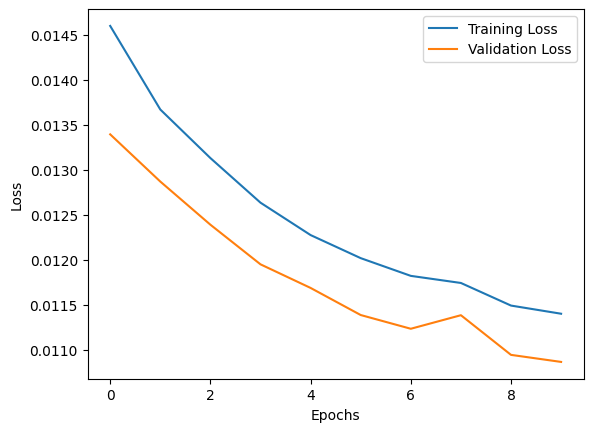

In [76]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



## 4. Sauvegarde de l'autoencodeur

In [79]:
autoencoder.save('livrable_2_autoencoder.keras')  # Sauvegarde du modèle

In [82]:
autoencoder_metrics = autoencoder.history.history
# Assuming you have a test dataset called test_data
predictions = autoencoder.predict(validation_dataset, batch_size=BATCH_SIZE)
print(autoencoder_metrics)


ResourceExhaustedError: Graph execution error:

Detected at node functional_9_1/up_sampling2d_14_1/Repeat_1/Tile defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 638, in run_forever

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1971, in _run_once

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 84, in _run

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 542, in dispatch_queue

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 531, in process_one

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 359, in execute_request

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 775, in execute_request

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 446, in do_execute

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3106, in _run_cell

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3311, in run_cell_async

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3493, in run_ast_nodes

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code

  File "C:\Users\Dias Bruno\AppData\Local\Temp\ipykernel_26588\2045269289.py", line 3, in <module>

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 515, in predict

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 213, in one_step_on_data_distributed

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 202, in one_step_on_data

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 94, in predict_step

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py", line 814, in __call__

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py", line 194, in call

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\function.py", line 151, in _run_through_graph

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py", line 578, in call

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py", line 814, in __call__

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\up_sampling2d.py", line 105, in call

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\up_sampling2d.py", line 156, in _resize_images

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\numpy.py", line 4473, in repeat

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 1531, in repeat

OOM when allocating tensor with shape[29,224,112,2,32] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu
	 [[{{node functional_9_1/up_sampling2d_14_1/Repeat_1/Tile}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_data_distributed_15163]

In [77]:
import matplotlib.pyplot as plt

# Assuming your model's history object is named 'history'
loss = history.history['loss']
accuracy = history.history['accuracy']

epochs = range(1, len(loss) + 1)

# Plotting the training loss
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training accuracy
plt.plot(epochs, accuracy, 'r', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


KeyError: 'accuracy'